In [73]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve,GridSearchCV
import shap
from shap import TreeExplainer

data = pd.read_csv("data.csv")
data.shape

(101766, 50)

In [2]:
#Remove "[", ")", ">", and "<"
data['age']=data['age'].str.replace('[','')
data['age']=data['age'].str.replace(')','')
data['weight']=data['weight'].str.replace('[','')
data['weight']=data['weight'].str.replace(')','')
data['max_glu_serum']=data['max_glu_serum'].str.replace('>','greater_than_')
data['A1Cresult']=data['A1Cresult'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('<','smaller_than_')


# Missing Values
Want to drop medical_specialty,weight ,payer_code for sure

In [3]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [4]:
data['readmitted_urgent'] = (data['readmitted'] == 'smaller_than_30').astype(int)

In [5]:
#Create new variable 'readmitted_yes' for binary classification
data['readmitted_yes']= (data['readmitted'] == 'greater_than_30').astype(int) +  (data['readmitted'] == 'smaller_than_30').astype(int) 

In [6]:
data.groupby(["readmitted_yes"])['readmitted_yes'].count()

readmitted_yes
0    54864
1    46902
Name: readmitted_yes, dtype: int64

In [7]:
data.groupby(["readmitted_urgent"])['readmitted_urgent'].count()

readmitted_urgent
0    90409
1    11357
Name: readmitted_urgent, dtype: int64

In [8]:
# Encode change column, diabetesMed column
# ch to Yes to 1, No to 1 
# gender: Male to 1, Female to 0
# DiabetesMed: Yed to 1, No to 0

In [9]:
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)
data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)


In [10]:
# there are 24 features of medicine,which indicates whether the drug 
# was prescribed or there was a change in the dosage
# Possible values: “up” if the dosage was increased during the encounter, 
# “down” if the dosage was decreased, “steady” if the dosage did not change,
# and “no” if the drug was not prescribed

meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
        'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

In [11]:
# Encode Up to 3, steady to 2, down to 1, no to 0
for col in meds:
    data[col] = data[col].replace('No', 0)
    data[col] = data[col].replace('Steady', 2)
    data[col] = data[col].replace('Up', 3)
    data[col] = data[col].replace('Down', 1)

In [12]:
data.groupby(['age'])['age'].count()

age
0-10        161
10-20       691
20-30      1657
30-40      3775
40-50      9685
50-60     17256
60-70     22483
70-80     26068
80-90     17197
90-100     2793
Name: age, dtype: int64

In [13]:

# Convert age to numerical, take the mid point of each interval, 5,15,25, etc

data['age'] = data['age'].replace('0-10', 5)
data['age'] = data['age'].replace('10-20', 15)
data['age'] = data['age'].replace('20-30', 25)
data['age'] = data['age'].replace('30-40', 35)
data['age'] = data['age'].replace('40-50', 45)
data['age'] = data['age'].replace('50-60', 55)
data['age'] = data['age'].replace('60-70', 65)
data['age'] = data['age'].replace('70-80', 75)
data['age'] = data['age'].replace('80-90', 85)
data['age'] = data['age'].replace('90-100', 95)

In [14]:
# convert examide and citoglipton to binary
data.groupby(['examide'])['examide'].count()
data.groupby(['citoglipton'])['citoglipton'].count()
# No need, all values are NO, just drop them

citoglipton
No    101766
Name: citoglipton, dtype: int64

In [15]:
# Drop payer_code, weight, medical_specialty, readmitted, examide, citoglipton
del_columns = ['weight', 'payer_code', 'medical_specialty','examide','citoglipton','readmitted']
data.drop(del_columns, inplace=True, axis=1)

In [16]:
id_list = []
encounter_list = []
for index, row in data.iterrows():
    if row['patient_nbr'] not in id_list:
        id_list.append(row['patient_nbr'])
        encounter_list.append(index)


In [17]:
df = data.iloc[list(encounter_list),:]

In [18]:
del_col = ["encounter_id","patient_nbr"]
df.drop(del_col, inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
df.drop(df[df.discharge_disposition_id == 11].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 13].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 14].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 19].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 20].index, inplace=True)
df.drop(df[df.discharge_disposition_id == 21].index, inplace=True)

In [20]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [21]:
df.shape

(69970, 44)

In [22]:
# Recode diag1, diag2, diag3

df.loc[df['diag_1'].str.contains('V'), ['diag_1']] = "SUPPLEMENTARY"
df.loc[df['diag_2'].str.contains('V'), ['diag_2']] = "SUPPLEMENTARY"
df.loc[df['diag_3'].str.contains('V'), ['diag_3']] = "SUPPLEMENTARY"

df.loc[df['diag_1'].str.contains('E'), ['diag_1']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_2'].str.contains('E'), ['diag_2']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_3'].str.contains('E'), ['diag_3']] = "SUPPLEMENTARY_EXTERNAL"

df['diag_1'] = df['diag_1'].replace('?', "NONE")
df['diag_2'] = df['diag_2'].replace('?', "NONE")
df['diag_3'] = df['diag_3'].replace('?', "NONE")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
df.to_csv("~/Desktop/new_data.csv",index=False)

In [24]:
#df['diag_1'] = pd.to_numeric(df['diag_1'], errors='ignore')
#df['diag_2']= pd.to_numeric(df['diag_2'], errors='ignore')
#df['diag_3']= pd.to_numeric(df['diag_3'], errors='ignore')

In [25]:
# Helper function to convert str to float
def change_to_num(col):
    res = []
    for i in col:
        if i not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
            res.append(float(i))
        else:
            res.append(i)
    return res
        

In [26]:
df['diag_1'] = change_to_num(df['diag_1'])
df['diag_2'] = change_to_num(df['diag_2'])
df['diag_3'] = change_to_num(df['diag_3'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
df['diag_1']

0                         250.83
1                            276
2                            648
3                              8
4                            197
5                            414
6                            414
7                            428
8                            398
9                            434
10                         250.7
11                           157
12                           428
13                           428
14                           518
15                           999
16                           410
17                           682
18                           402
19                           737
20                           410
21                           572
22                           410
23        SUPPLEMENTARY_EXTERNAL
24                           189
25                           786
26                           427
27                           996
28                           277
29                           428
          

In [28]:
new_diag_1 = []
for index, row in df.iterrows():
    if row['diag_1'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_1'] >= 1 and row['diag_1'] <= 139):
            new_diag_1.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_1'] >= 140 and row['diag_1'] <= 239):
            new_diag_1.append("NEOPLASMS")
        elif (row['diag_1'] >= 240 and row['diag_1'] <= 279):
            new_diag_1.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_1'] >= 280 and row['diag_1'] <= 289):
            new_diag_1.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_1'] >= 290 and row['diag_1'] <= 319):
            new_diag_1.append("MENTAL_DISORDER")
        elif (row['diag_1'] >= 320 and row['diag_1'] <= 389):
            new_diag_1.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_1'] >= 390 and row['diag_1'] <= 459):
            new_diag_1.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 460 and row['diag_1'] <= 519):
            new_diag_1.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 520 and row['diag_1'] <= 579):
            new_diag_1.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 580 and row['diag_1'] <= 629):
            new_diag_1.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 630 and row['diag_1'] <= 679):
            new_diag_1.append("PREGNANCY")
        elif (row['diag_1'] >= 680 and row['diag_1'] <= 709):
            new_diag_1.append("SKIN_DISEASE")
        elif (row['diag_1'] >= 710 and row['diag_1'] <= 739):
            new_diag_1.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 740 and row['diag_1'] <= 759):
            new_diag_1.append("CONGENITAL_ANOMALIES")
        elif (row['diag_1'] >= 760 and row['diag_1'] <= 779):
            new_diag_1.append("PERINATAL_PERIOD")
        elif (row['diag_1'] >= 780 and row['diag_1'] <= 799):
            new_diag_1.append("ILL_DEFINED_COND")
        elif (row['diag_1'] >= 800 and row['diag_1'] <= 999):
            new_diag_1.append("INJURY_POISONING")
    else:
        new_diag_1.append(row['diag_1'])


In [29]:
df['diag_1'] = pd.Series(new_diag_1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
new_diag_2 = []
for index, row in df.iterrows():
    if row['diag_2'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_2'] >= 1 and row['diag_2'] <= 139):
            new_diag_2.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_2'] >= 140 and row['diag_2'] <= 239):
            new_diag_2.append("NEOPLASMS")
        elif (row['diag_2'] >= 240 and row['diag_2'] <= 279):
            new_diag_2.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_2'] >= 280 and row['diag_2'] <= 289):
            new_diag_2.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_2'] >= 290 and row['diag_2'] <= 319):
            new_diag_2.append("MENTAL_DISORDER")
        elif (row['diag_2'] >= 320 and row['diag_2'] <= 389):
            new_diag_2.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_2'] >= 390 and row['diag_2'] <= 459):
            new_diag_2.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 460 and row['diag_2'] <= 519):
            new_diag_2.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 520 and row['diag_2'] <= 579):
            new_diag_2.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 580 and row['diag_2'] <= 629):
            new_diag_2.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 630 and row['diag_2'] <= 679):
            new_diag_2.append("PREGNANCY")
        elif (row['diag_2'] >= 680 and row['diag_2'] <= 709):
            new_diag_2.append("SKIN_DISEASE")
        elif (row['diag_2'] >= 710 and row['diag_2'] <= 739):
            new_diag_2.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 740 and row['diag_2'] <= 759):
            new_diag_2.append("CONGENITAL_ANOMALIES")
        elif (row['diag_2'] >= 760 and row['diag_2'] <= 779):
            new_diag_2.append("PERINATAL_PERIOD")
        elif (row['diag_2'] >= 780 and row['diag_2'] <= 799):
            new_diag_2.append("ILL_DEFINED_COND")
        elif (row['diag_2'] >= 800 and row['diag_2'] <= 999):
            new_diag_2.append("INJURY_POISONING")
    else:
        new_diag_2.append(row['diag_2'])

df['diag_2'] = pd.Series(new_diag_2)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
new_diag_3 = []
for index, row in df.iterrows():
    if row['diag_3'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_3'] >= 1 and row['diag_3'] <= 139):
            new_diag_3.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_3'] >= 140 and row['diag_3'] <= 239):
            new_diag_3.append("NEOPLASMS")
        elif (row['diag_3'] >= 240 and row['diag_3'] <= 279):
            new_diag_3.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_3'] >= 280 and row['diag_3'] <= 289):
            new_diag_3.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_3'] >= 290 and row['diag_3'] <= 319):
            new_diag_3.append("MENTAL_DISORDER")
        elif (row['diag_3'] >= 320 and row['diag_3'] <= 389):
            new_diag_3.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_3'] >= 390 and row['diag_3'] <= 459):
            new_diag_3.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 460 and row['diag_3'] <= 519):
            new_diag_3.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 520 and row['diag_3'] <= 579):
            new_diag_3.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 580 and row['diag_3'] <= 629):
            new_diag_3.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 630 and row['diag_3'] <= 679):
            new_diag_3.append("PREGNANCY")
        elif (row['diag_3'] >= 680 and row['diag_3'] <= 709):
            new_diag_3.append("SKIN_DISEASE")
        elif (row['diag_3'] >= 710 and row['diag_3'] <= 739):
            new_diag_3.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 740 and row['diag_3'] <= 759):
            new_diag_3.append("CONGENITAL_ANOMALIES")
        elif (row['diag_3'] >= 760 and row['diag_3'] <= 779):
            new_diag_3.append("PERINATAL_PERIOD")
        elif (row['diag_3'] >= 780 and row['diag_3'] <= 799):
            new_diag_3.append("ILL_DEFINED_COND")
        elif (row['diag_3'] >= 800 and row['diag_3'] <= 999):
            new_diag_3.append("INJURY_POISONING")
    else:
        new_diag_3.append(row['diag_3'])

df['diag_3'] = pd.Series(new_diag_3)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
df.to_csv("~/Desktop/recode_data.csv",index=False)

In [33]:
df.groupby(['gender'])['gender'].count()

gender
Female    37229
Male      32741
Name: gender, dtype: int64

In [34]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [35]:
df.groupby(['gender'])['gender'].count()

gender
Female    37229
Male      32741
Name: gender, dtype: int64

In [36]:
df_2 = pd.get_dummies(df, columns=['diag_1','diag_2','diag_3','max_glu_serum',
                                   'A1Cresult','race','gender',
                                   'admission_type_id',
                                   'discharge_disposition_id','admission_source_id'], drop_first=True)

In [37]:
df_2.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin',
       ...
       'admission_source_id_8', 'admission_source_id_9',
       'admission_source_id_10', 'admission_source_id_11',
       'admission_source_id_13', 'admission_source_id_14',
       'admission_source_id_17', 'admission_source_id_20',
       'admission_source_id_22', 'admission_source_id_25'],
      dtype='object', length=140)

In [38]:
#Construct predicted variable 'readmitted_yes' and predictors
Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_urgent',axis=1)
X=X.drop('readmitted_yes',axis=1)
seed = 7
test_size = 0.33
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [39]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

Series.base is deprecated and will be removed in a future version


In [40]:
#Define function for tuning the number of estimators
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        dtrain = xgb.DMatrix(X_train, label=y_train)
        xgb_param = alg.get_xgb_params()
        xgtrain = dtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nthe best number of trees is ", cvresult.shape[0])
    print("\nModel Report")
    print ("Accuracy : %.4g" % sklearn.metrics.accuracy_score(y_train, dtrain_predictions))
    print ("AUC Score (Train): %f" % sklearn.metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    xgb.plot_importance(alg, max_num_features=20)


the best number of trees is  225

Model Report
Accuracy : 0.6905
AUC Score (Train): 0.744665


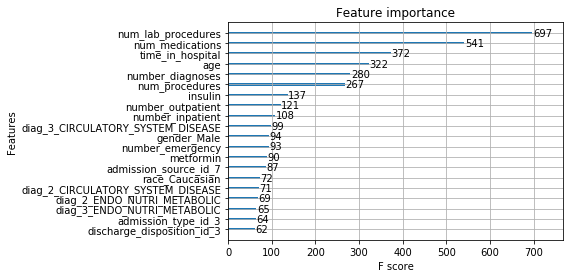

In [41]:
#Tune the number of estimators
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, Y_train)

In [260]:
#Tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(2,8,2),
 'min_child_weight':range(0,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=225, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_

{'max_depth': 4, 'min_child_weight': 4}

In [261]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':[3,4,5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=225, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_

{'max_depth': 4, 'min_child_weight': 3}

In [262]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=225, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_

{'gamma': 0.0}

Series.base is deprecated and will be removed in a future version



the best number of trees is  344

Model Report
Accuracy : 0.6788
AUC Score (Train): 0.727349


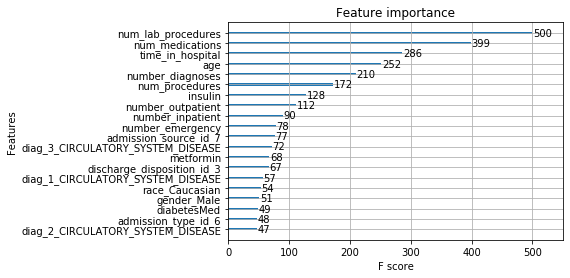

In [263]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=4,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train, Y_train)

In [264]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=344, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.6}

In [265]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=344, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_

{'reg_alpha': 1}

In [266]:
param_test6 = {
 'reg_alpha':[1, 5, 10]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=344, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.6, reg_alpha=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_

{'reg_alpha': 5}

Series.base is deprecated and will be removed in a future version



the best number of trees is  344

Model Report
Accuracy : 0.6673
AUC Score (Train): 0.710432


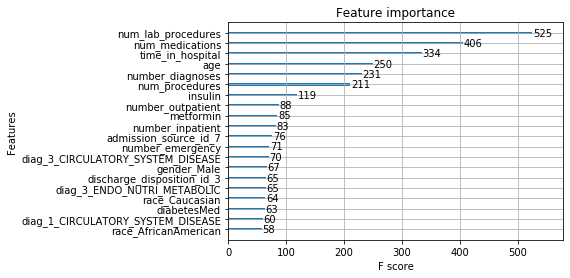

In [267]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.6, 
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, Y_train)

Series.base is deprecated and will be removed in a future version



the best number of trees is  2944

Model Report
Accuracy : 0.665
AUC Score (Train): 0.707981


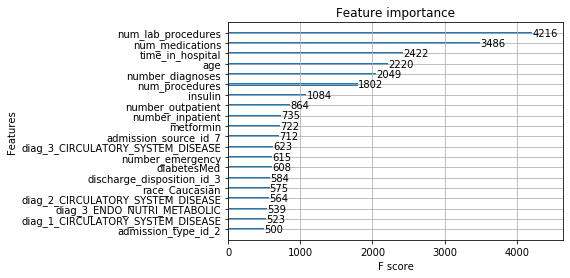

In [274]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.6,
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, Y_train)

In [42]:
model_param = {'max_depth': 4,'min_child_weight': 3, 'eta': 0.01, 'gamma': 0, 'subsample': 0.6,'colsample_bytree': 0.6,'reg_alpha': 5,'objective': 'binary:logistic','nthread': 4,'scale_pos_weight': 1,'seed': 27,'eval_metric': 'auc'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round=2944
model = xgb.train(model_param, dtrain, num_round, evallist)

[0]	eval-auc:0.599713	train-auc:0.597081
[1]	eval-auc:0.61698	train-auc:0.618153
[2]	eval-auc:0.625108	train-auc:0.624292
[3]	eval-auc:0.630917	train-auc:0.629428
[4]	eval-auc:0.633489	train-auc:0.631664
[5]	eval-auc:0.632957	train-auc:0.631134
[6]	eval-auc:0.636212	train-auc:0.635422
[7]	eval-auc:0.635738	train-auc:0.63549
[8]	eval-auc:0.636422	train-auc:0.635123
[9]	eval-auc:0.639069	train-auc:0.637522
[10]	eval-auc:0.638611	train-auc:0.636665
[11]	eval-auc:0.639108	train-auc:0.637632
[12]	eval-auc:0.638666	train-auc:0.637654
[13]	eval-auc:0.639777	train-auc:0.638389
[14]	eval-auc:0.639574	train-auc:0.638363
[15]	eval-auc:0.640099	train-auc:0.638514
[16]	eval-auc:0.64091	train-auc:0.639323
[17]	eval-auc:0.64194	train-auc:0.640802
[18]	eval-auc:0.642004	train-auc:0.640645
[19]	eval-auc:0.642188	train-auc:0.640761
[20]	eval-auc:0.64291	train-auc:0.641361
[21]	eval-auc:0.642954	train-auc:0.641265
[22]	eval-auc:0.642829	train-auc:0.641153
[23]	eval-auc:0.642979	train-auc:0.641411
[24]	ev

[194]	eval-auc:0.651156	train-auc:0.651422
[195]	eval-auc:0.651197	train-auc:0.651451
[196]	eval-auc:0.651218	train-auc:0.651444
[197]	eval-auc:0.651215	train-auc:0.651443
[198]	eval-auc:0.651268	train-auc:0.651495
[199]	eval-auc:0.651294	train-auc:0.651517
[200]	eval-auc:0.651294	train-auc:0.65152
[201]	eval-auc:0.651358	train-auc:0.651596
[202]	eval-auc:0.65134	train-auc:0.651618
[203]	eval-auc:0.651452	train-auc:0.651775
[204]	eval-auc:0.651513	train-auc:0.651803
[205]	eval-auc:0.651567	train-auc:0.651876
[206]	eval-auc:0.651626	train-auc:0.651916
[207]	eval-auc:0.651643	train-auc:0.651945
[208]	eval-auc:0.651661	train-auc:0.651962
[209]	eval-auc:0.651705	train-auc:0.652038
[210]	eval-auc:0.6517	train-auc:0.652068
[211]	eval-auc:0.651764	train-auc:0.652136
[212]	eval-auc:0.651846	train-auc:0.652269
[213]	eval-auc:0.651943	train-auc:0.652369
[214]	eval-auc:0.651969	train-auc:0.652421
[215]	eval-auc:0.652027	train-auc:0.652508
[216]	eval-auc:0.652116	train-auc:0.652597
[217]	eval-auc:

[386]	eval-auc:0.658724	train-auc:0.662034
[387]	eval-auc:0.658742	train-auc:0.662086
[388]	eval-auc:0.658791	train-auc:0.662162
[389]	eval-auc:0.658805	train-auc:0.66217
[390]	eval-auc:0.658834	train-auc:0.662246
[391]	eval-auc:0.65887	train-auc:0.662299
[392]	eval-auc:0.658903	train-auc:0.662329
[393]	eval-auc:0.658932	train-auc:0.662397
[394]	eval-auc:0.658965	train-auc:0.662439
[395]	eval-auc:0.658999	train-auc:0.662476
[396]	eval-auc:0.659019	train-auc:0.662492
[397]	eval-auc:0.659028	train-auc:0.662507
[398]	eval-auc:0.659077	train-auc:0.662562
[399]	eval-auc:0.659089	train-auc:0.662598
[400]	eval-auc:0.65909	train-auc:0.66264
[401]	eval-auc:0.659123	train-auc:0.662687
[402]	eval-auc:0.659132	train-auc:0.662735
[403]	eval-auc:0.659185	train-auc:0.662796
[404]	eval-auc:0.659191	train-auc:0.662832
[405]	eval-auc:0.659221	train-auc:0.662889
[406]	eval-auc:0.659268	train-auc:0.662933
[407]	eval-auc:0.659305	train-auc:0.662984
[408]	eval-auc:0.659338	train-auc:0.663025
[409]	eval-auc:

[578]	eval-auc:0.663439	train-auc:0.66978
[579]	eval-auc:0.663431	train-auc:0.669793
[580]	eval-auc:0.663443	train-auc:0.669809
[581]	eval-auc:0.663473	train-auc:0.669842
[582]	eval-auc:0.663478	train-auc:0.669889
[583]	eval-auc:0.663491	train-auc:0.669932
[584]	eval-auc:0.663513	train-auc:0.669976
[585]	eval-auc:0.66353	train-auc:0.670014
[586]	eval-auc:0.66354	train-auc:0.670049
[587]	eval-auc:0.663561	train-auc:0.670092
[588]	eval-auc:0.663605	train-auc:0.670125
[589]	eval-auc:0.663627	train-auc:0.670149
[590]	eval-auc:0.663664	train-auc:0.670205
[591]	eval-auc:0.663681	train-auc:0.670242
[592]	eval-auc:0.66369	train-auc:0.670277
[593]	eval-auc:0.663703	train-auc:0.670322
[594]	eval-auc:0.663729	train-auc:0.670363
[595]	eval-auc:0.663746	train-auc:0.670413
[596]	eval-auc:0.66377	train-auc:0.670483
[597]	eval-auc:0.663793	train-auc:0.670537
[598]	eval-auc:0.663797	train-auc:0.670571
[599]	eval-auc:0.663817	train-auc:0.670599
[600]	eval-auc:0.663839	train-auc:0.670642
[601]	eval-auc:0

[770]	eval-auc:0.666143	train-auc:0.675822
[771]	eval-auc:0.666173	train-auc:0.675856
[772]	eval-auc:0.666197	train-auc:0.675889
[773]	eval-auc:0.66619	train-auc:0.675903
[774]	eval-auc:0.666219	train-auc:0.675923
[775]	eval-auc:0.666223	train-auc:0.675944
[776]	eval-auc:0.666232	train-auc:0.675969
[777]	eval-auc:0.666236	train-auc:0.675985
[778]	eval-auc:0.666264	train-auc:0.676021
[779]	eval-auc:0.666276	train-auc:0.676032
[780]	eval-auc:0.666286	train-auc:0.676055
[781]	eval-auc:0.666291	train-auc:0.676079
[782]	eval-auc:0.666297	train-auc:0.676112
[783]	eval-auc:0.666293	train-auc:0.676138
[784]	eval-auc:0.666314	train-auc:0.676163
[785]	eval-auc:0.666318	train-auc:0.676181
[786]	eval-auc:0.66632	train-auc:0.6762
[787]	eval-auc:0.66633	train-auc:0.676222
[788]	eval-auc:0.666338	train-auc:0.676238
[789]	eval-auc:0.666354	train-auc:0.676257
[790]	eval-auc:0.666345	train-auc:0.676282
[791]	eval-auc:0.666352	train-auc:0.676308
[792]	eval-auc:0.666387	train-auc:0.676344
[793]	eval-auc:0

[962]	eval-auc:0.668093	train-auc:0.680163
[963]	eval-auc:0.668107	train-auc:0.680174
[964]	eval-auc:0.668113	train-auc:0.680189
[965]	eval-auc:0.668119	train-auc:0.680218
[966]	eval-auc:0.668128	train-auc:0.680234
[967]	eval-auc:0.668139	train-auc:0.680261
[968]	eval-auc:0.66815	train-auc:0.680276
[969]	eval-auc:0.668157	train-auc:0.680297
[970]	eval-auc:0.668174	train-auc:0.680321
[971]	eval-auc:0.668196	train-auc:0.680351
[972]	eval-auc:0.668197	train-auc:0.680379
[973]	eval-auc:0.668205	train-auc:0.680399
[974]	eval-auc:0.668221	train-auc:0.68042
[975]	eval-auc:0.668227	train-auc:0.680439
[976]	eval-auc:0.668242	train-auc:0.680458
[977]	eval-auc:0.668262	train-auc:0.680474
[978]	eval-auc:0.668285	train-auc:0.680506
[979]	eval-auc:0.66829	train-auc:0.680511
[980]	eval-auc:0.668303	train-auc:0.680533
[981]	eval-auc:0.668315	train-auc:0.680555
[982]	eval-auc:0.66833	train-auc:0.680583
[983]	eval-auc:0.668328	train-auc:0.680597
[984]	eval-auc:0.668327	train-auc:0.68062
[985]	eval-auc:0

[1151]	eval-auc:0.66958	train-auc:0.683794
[1152]	eval-auc:0.669593	train-auc:0.683813
[1153]	eval-auc:0.669598	train-auc:0.68382
[1154]	eval-auc:0.669597	train-auc:0.683835
[1155]	eval-auc:0.669632	train-auc:0.683877
[1156]	eval-auc:0.669634	train-auc:0.683888
[1157]	eval-auc:0.669636	train-auc:0.683904
[1158]	eval-auc:0.669646	train-auc:0.683938
[1159]	eval-auc:0.669654	train-auc:0.683958
[1160]	eval-auc:0.669662	train-auc:0.683969
[1161]	eval-auc:0.669671	train-auc:0.683989
[1162]	eval-auc:0.669683	train-auc:0.684022
[1163]	eval-auc:0.669705	train-auc:0.684056
[1164]	eval-auc:0.669718	train-auc:0.684095
[1165]	eval-auc:0.669745	train-auc:0.684138
[1166]	eval-auc:0.669747	train-auc:0.684161
[1167]	eval-auc:0.669767	train-auc:0.684188
[1168]	eval-auc:0.669773	train-auc:0.684194
[1169]	eval-auc:0.669785	train-auc:0.684211
[1170]	eval-auc:0.669799	train-auc:0.684228
[1171]	eval-auc:0.669806	train-auc:0.684242
[1172]	eval-auc:0.669813	train-auc:0.684273
[1173]	eval-auc:0.669827	train-auc

[1339]	eval-auc:0.671042	train-auc:0.687315
[1340]	eval-auc:0.671051	train-auc:0.687328
[1341]	eval-auc:0.671056	train-auc:0.687343
[1342]	eval-auc:0.671063	train-auc:0.68735
[1343]	eval-auc:0.671064	train-auc:0.687364
[1344]	eval-auc:0.671084	train-auc:0.687387
[1345]	eval-auc:0.671084	train-auc:0.687409
[1346]	eval-auc:0.671093	train-auc:0.687426
[1347]	eval-auc:0.671094	train-auc:0.687432
[1348]	eval-auc:0.671101	train-auc:0.687444
[1349]	eval-auc:0.67109	train-auc:0.687462
[1350]	eval-auc:0.671094	train-auc:0.687475
[1351]	eval-auc:0.67109	train-auc:0.687491
[1352]	eval-auc:0.671101	train-auc:0.687509
[1353]	eval-auc:0.671109	train-auc:0.687514
[1354]	eval-auc:0.671117	train-auc:0.68753
[1355]	eval-auc:0.67112	train-auc:0.687536
[1356]	eval-auc:0.671115	train-auc:0.687555
[1357]	eval-auc:0.671125	train-auc:0.687574
[1358]	eval-auc:0.671125	train-auc:0.687585
[1359]	eval-auc:0.671139	train-auc:0.687606
[1360]	eval-auc:0.671151	train-auc:0.687625
[1361]	eval-auc:0.67116	train-auc:0.6

[1526]	eval-auc:0.672051	train-auc:0.690288
[1527]	eval-auc:0.672046	train-auc:0.690295
[1528]	eval-auc:0.672046	train-auc:0.690314
[1529]	eval-auc:0.672067	train-auc:0.690335
[1530]	eval-auc:0.672082	train-auc:0.690353
[1531]	eval-auc:0.672082	train-auc:0.690363
[1532]	eval-auc:0.672095	train-auc:0.690367
[1533]	eval-auc:0.672108	train-auc:0.690402
[1534]	eval-auc:0.672108	train-auc:0.690411
[1535]	eval-auc:0.67212	train-auc:0.690423
[1536]	eval-auc:0.672125	train-auc:0.690437
[1537]	eval-auc:0.672134	train-auc:0.690467
[1538]	eval-auc:0.672138	train-auc:0.690487
[1539]	eval-auc:0.672157	train-auc:0.690516
[1540]	eval-auc:0.672172	train-auc:0.690529
[1541]	eval-auc:0.67219	train-auc:0.690555
[1542]	eval-auc:0.67219	train-auc:0.690572
[1543]	eval-auc:0.672197	train-auc:0.690583
[1544]	eval-auc:0.67221	train-auc:0.690618
[1545]	eval-auc:0.672219	train-auc:0.690633
[1546]	eval-auc:0.672228	train-auc:0.690647
[1547]	eval-auc:0.672225	train-auc:0.690657
[1548]	eval-auc:0.672224	train-auc:0

[1714]	eval-auc:0.673079	train-auc:0.693193
[1715]	eval-auc:0.673091	train-auc:0.693224
[1716]	eval-auc:0.673095	train-auc:0.693263
[1717]	eval-auc:0.673096	train-auc:0.693279
[1718]	eval-auc:0.673099	train-auc:0.693286
[1719]	eval-auc:0.673094	train-auc:0.693294
[1720]	eval-auc:0.67309	train-auc:0.693308
[1721]	eval-auc:0.67311	train-auc:0.693346
[1722]	eval-auc:0.673108	train-auc:0.693362
[1723]	eval-auc:0.673109	train-auc:0.693381
[1724]	eval-auc:0.673112	train-auc:0.693392
[1725]	eval-auc:0.673107	train-auc:0.693399
[1726]	eval-auc:0.673101	train-auc:0.693414
[1727]	eval-auc:0.673116	train-auc:0.693427
[1728]	eval-auc:0.673119	train-auc:0.693434
[1729]	eval-auc:0.673133	train-auc:0.693451
[1730]	eval-auc:0.673137	train-auc:0.693468
[1731]	eval-auc:0.673142	train-auc:0.693479
[1732]	eval-auc:0.673143	train-auc:0.693487
[1733]	eval-auc:0.673147	train-auc:0.693497
[1734]	eval-auc:0.67315	train-auc:0.693512
[1735]	eval-auc:0.673142	train-auc:0.693528
[1736]	eval-auc:0.673155	train-auc:

[1902]	eval-auc:0.673723	train-auc:0.695976
[1903]	eval-auc:0.673738	train-auc:0.696005
[1904]	eval-auc:0.673738	train-auc:0.696017
[1905]	eval-auc:0.673743	train-auc:0.696037
[1906]	eval-auc:0.673748	train-auc:0.696042
[1907]	eval-auc:0.67375	train-auc:0.696053
[1908]	eval-auc:0.673742	train-auc:0.696057
[1909]	eval-auc:0.673746	train-auc:0.696064
[1910]	eval-auc:0.673752	train-auc:0.696077
[1911]	eval-auc:0.673752	train-auc:0.696084
[1912]	eval-auc:0.67375	train-auc:0.696092
[1913]	eval-auc:0.67376	train-auc:0.696111
[1914]	eval-auc:0.673764	train-auc:0.696118
[1915]	eval-auc:0.673776	train-auc:0.69613
[1916]	eval-auc:0.673778	train-auc:0.696136
[1917]	eval-auc:0.673775	train-auc:0.696136
[1918]	eval-auc:0.673774	train-auc:0.69615
[1919]	eval-auc:0.673772	train-auc:0.696167
[1920]	eval-auc:0.67377	train-auc:0.696188
[1921]	eval-auc:0.673774	train-auc:0.696197
[1922]	eval-auc:0.673779	train-auc:0.696206
[1923]	eval-auc:0.673776	train-auc:0.696209
[1924]	eval-auc:0.673776	train-auc:0.6

[2090]	eval-auc:0.674323	train-auc:0.698286
[2091]	eval-auc:0.67432	train-auc:0.698296
[2092]	eval-auc:0.67433	train-auc:0.698312
[2093]	eval-auc:0.674322	train-auc:0.698324
[2094]	eval-auc:0.674321	train-auc:0.698341
[2095]	eval-auc:0.674331	train-auc:0.698366
[2096]	eval-auc:0.674338	train-auc:0.698372
[2097]	eval-auc:0.674346	train-auc:0.698378
[2098]	eval-auc:0.674357	train-auc:0.69839
[2099]	eval-auc:0.674367	train-auc:0.698404
[2100]	eval-auc:0.674365	train-auc:0.698422
[2101]	eval-auc:0.674367	train-auc:0.698431
[2102]	eval-auc:0.674381	train-auc:0.698446
[2103]	eval-auc:0.674384	train-auc:0.698461
[2104]	eval-auc:0.674392	train-auc:0.698485
[2105]	eval-auc:0.674395	train-auc:0.698505
[2106]	eval-auc:0.674394	train-auc:0.698514
[2107]	eval-auc:0.674392	train-auc:0.698531
[2108]	eval-auc:0.674396	train-auc:0.698545
[2109]	eval-auc:0.674402	train-auc:0.698556
[2110]	eval-auc:0.674416	train-auc:0.698573
[2111]	eval-auc:0.674417	train-auc:0.698583
[2112]	eval-auc:0.674427	train-auc:

[2278]	eval-auc:0.674859	train-auc:0.700652
[2279]	eval-auc:0.674861	train-auc:0.700659
[2280]	eval-auc:0.674869	train-auc:0.700674
[2281]	eval-auc:0.674874	train-auc:0.700693
[2282]	eval-auc:0.674877	train-auc:0.700716
[2283]	eval-auc:0.674884	train-auc:0.700731
[2284]	eval-auc:0.674886	train-auc:0.700736
[2285]	eval-auc:0.67489	train-auc:0.700751
[2286]	eval-auc:0.674897	train-auc:0.700768
[2287]	eval-auc:0.674893	train-auc:0.700782
[2288]	eval-auc:0.674897	train-auc:0.700797
[2289]	eval-auc:0.674893	train-auc:0.700814
[2290]	eval-auc:0.674903	train-auc:0.700832
[2291]	eval-auc:0.674901	train-auc:0.700847
[2292]	eval-auc:0.674899	train-auc:0.700857
[2293]	eval-auc:0.674909	train-auc:0.700879
[2294]	eval-auc:0.674909	train-auc:0.700895
[2295]	eval-auc:0.674902	train-auc:0.700914
[2296]	eval-auc:0.67491	train-auc:0.700929
[2297]	eval-auc:0.674906	train-auc:0.70094
[2298]	eval-auc:0.674904	train-auc:0.700945
[2299]	eval-auc:0.674913	train-auc:0.700956
[2300]	eval-auc:0.674917	train-auc:

[2466]	eval-auc:0.675212	train-auc:0.702866
[2467]	eval-auc:0.675206	train-auc:0.702873
[2468]	eval-auc:0.675203	train-auc:0.702886
[2469]	eval-auc:0.675207	train-auc:0.702901
[2470]	eval-auc:0.675222	train-auc:0.702915
[2471]	eval-auc:0.675215	train-auc:0.702923
[2472]	eval-auc:0.675227	train-auc:0.702948
[2473]	eval-auc:0.675227	train-auc:0.702954
[2474]	eval-auc:0.675238	train-auc:0.702961
[2475]	eval-auc:0.675242	train-auc:0.702973
[2476]	eval-auc:0.675237	train-auc:0.70298
[2477]	eval-auc:0.675235	train-auc:0.702986
[2478]	eval-auc:0.675238	train-auc:0.703011
[2479]	eval-auc:0.675251	train-auc:0.703028
[2480]	eval-auc:0.675252	train-auc:0.703039
[2481]	eval-auc:0.675255	train-auc:0.70305
[2482]	eval-auc:0.67526	train-auc:0.703062
[2483]	eval-auc:0.67526	train-auc:0.703071
[2484]	eval-auc:0.675261	train-auc:0.703072
[2485]	eval-auc:0.675261	train-auc:0.703085
[2486]	eval-auc:0.675264	train-auc:0.703103
[2487]	eval-auc:0.675262	train-auc:0.703115
[2488]	eval-auc:0.675265	train-auc:0

[2654]	eval-auc:0.675557	train-auc:0.704854
[2655]	eval-auc:0.675559	train-auc:0.704864
[2656]	eval-auc:0.675557	train-auc:0.704874
[2657]	eval-auc:0.675561	train-auc:0.704891
[2658]	eval-auc:0.675552	train-auc:0.704906
[2659]	eval-auc:0.675554	train-auc:0.704915
[2660]	eval-auc:0.675567	train-auc:0.704931
[2661]	eval-auc:0.675568	train-auc:0.704937
[2662]	eval-auc:0.675568	train-auc:0.70496
[2663]	eval-auc:0.675581	train-auc:0.704972
[2664]	eval-auc:0.675589	train-auc:0.704981
[2665]	eval-auc:0.675594	train-auc:0.704984
[2666]	eval-auc:0.675598	train-auc:0.704993
[2667]	eval-auc:0.675607	train-auc:0.705002
[2668]	eval-auc:0.675618	train-auc:0.705011
[2669]	eval-auc:0.675621	train-auc:0.705012
[2670]	eval-auc:0.675635	train-auc:0.705027
[2671]	eval-auc:0.675632	train-auc:0.705036
[2672]	eval-auc:0.675629	train-auc:0.705042
[2673]	eval-auc:0.675632	train-auc:0.705047
[2674]	eval-auc:0.675632	train-auc:0.705061
[2675]	eval-auc:0.675628	train-auc:0.705067
[2676]	eval-auc:0.675623	train-au

[2842]	eval-auc:0.675851	train-auc:0.706923
[2843]	eval-auc:0.675848	train-auc:0.706934
[2844]	eval-auc:0.675857	train-auc:0.706947
[2845]	eval-auc:0.675851	train-auc:0.706964
[2846]	eval-auc:0.675854	train-auc:0.706972
[2847]	eval-auc:0.675864	train-auc:0.706983
[2848]	eval-auc:0.675868	train-auc:0.706997
[2849]	eval-auc:0.675864	train-auc:0.70701
[2850]	eval-auc:0.675865	train-auc:0.707017
[2851]	eval-auc:0.675861	train-auc:0.707039
[2852]	eval-auc:0.675864	train-auc:0.707036
[2853]	eval-auc:0.675854	train-auc:0.707039
[2854]	eval-auc:0.675843	train-auc:0.707055
[2855]	eval-auc:0.675841	train-auc:0.707058
[2856]	eval-auc:0.675841	train-auc:0.707066
[2857]	eval-auc:0.67584	train-auc:0.707084
[2858]	eval-auc:0.675842	train-auc:0.707092
[2859]	eval-auc:0.675838	train-auc:0.7071
[2860]	eval-auc:0.675846	train-auc:0.70711
[2861]	eval-auc:0.675855	train-auc:0.707115
[2862]	eval-auc:0.675865	train-auc:0.707129
[2863]	eval-auc:0.675869	train-auc:0.707146
[2864]	eval-auc:0.675868	train-auc:0.

In [43]:
# evaluate training accuracy
y_train_pred = model.predict(dtrain)
predictions_train = []
for value in y_train_pred:
    if value <=0.5:
        predictions_train.append(0)
    else:
        predictions_train.append(1)
accuracy_train = sklearn.metrics.accuracy_score(Y_train, predictions_train)
print("Accuracy: %.2f%%" % (accuracy_train * 100.0))

Accuracy: 66.50%


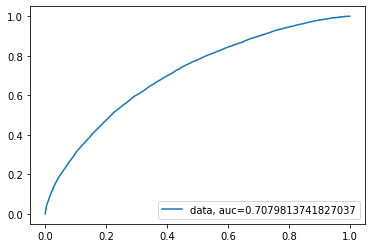

In [44]:
fpr, tpr, _ = sklearn.metrics.roc_curve(Y_train,  y_train_pred)
auc = sklearn.metrics.roc_auc_score(Y_train,  y_train_pred)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Accuracy: 64.71%


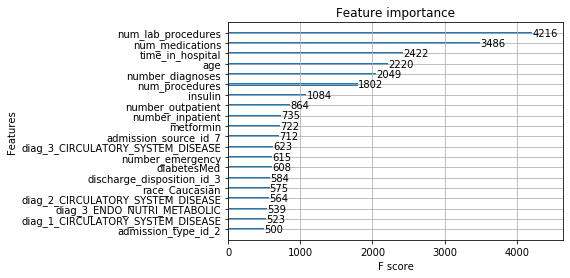

In [45]:
# evaluate predictions accuracy
ypred = model.predict(dtest)
predictions = []
for value in ypred:
    if value <=0.5:
        predictions.append(0)
    else:
        predictions.append(1)
accuracy = sklearn.metrics.accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#importance plot
xgb.plot_importance(model, max_num_features=20)

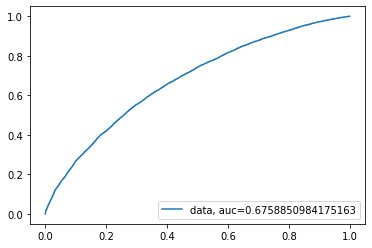

In [46]:
fpr, tpr, _ = sklearn.metrics.roc_curve(Y_test, ypred)
auc = sklearn.metrics.roc_auc_score(Y_test, ypred)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [87]:
shap_values=shap.TreeExplainer(model).shap_values(X_train)

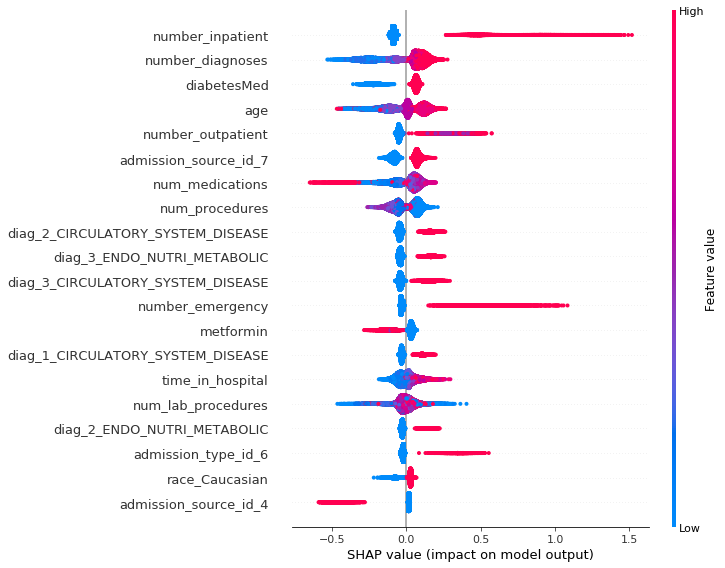

In [88]:
shap.summary_plot(shap_values,X_train)

In [89]:
shap_values2=shap.TreeExplainer(model).shap_values(X_test)

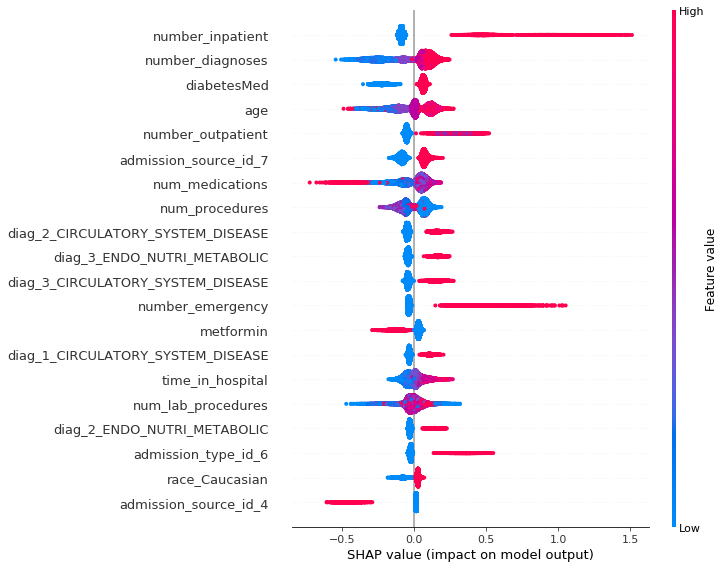

In [90]:
shap.summary_plot(shap_values2,X_test)

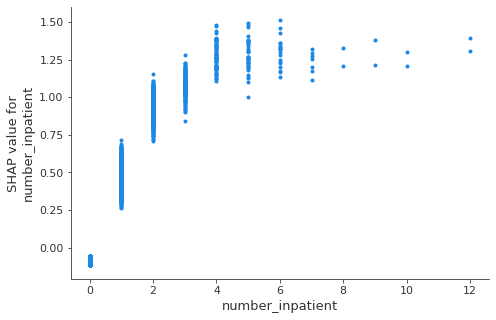

In [91]:
shap.dependence_plot("number_inpatient", shap_values2, X_test, interaction_index=None)

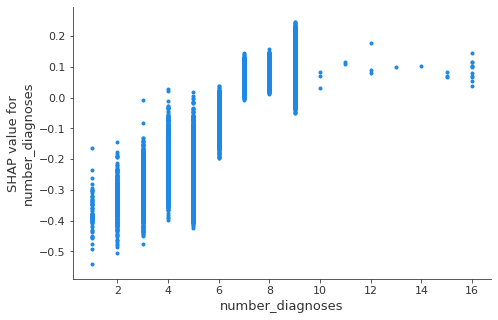

In [93]:
shap.dependence_plot("number_diagnoses", shap_values2, X_test, interaction_index=None)

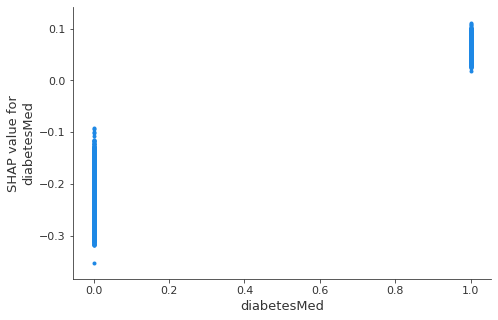

In [94]:
shap.dependence_plot("diabetesMed", shap_values2, X_test, interaction_index=None)

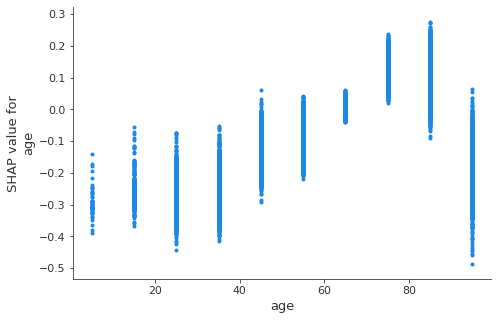

In [96]:
shap.dependence_plot("age", shap_values2, X_test, interaction_index=None)

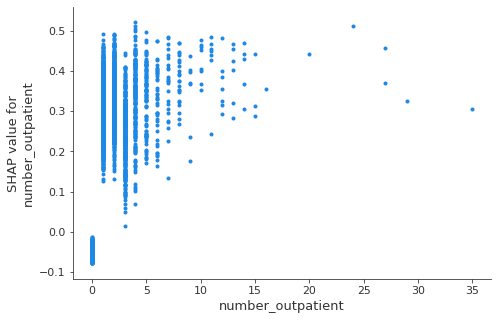

In [97]:
shap.dependence_plot("number_outpatient", shap_values2, X_test, interaction_index=None)

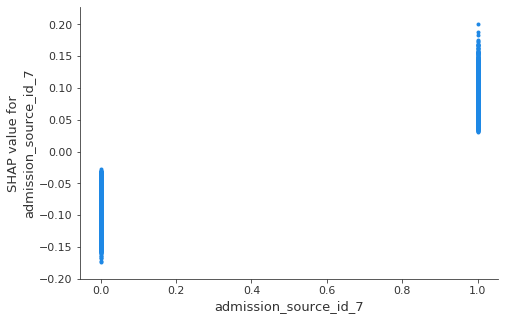

In [98]:
shap.dependence_plot("admission_source_id_7", shap_values2, X_test, interaction_index=None)

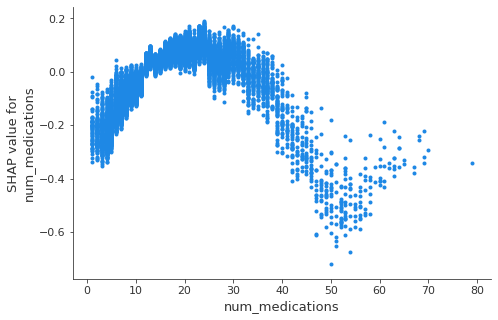

In [99]:
shap.dependence_plot("num_medications", shap_values2, X_test, interaction_index=None)

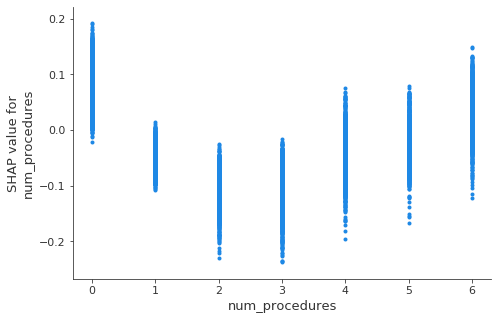

In [101]:
shap.dependence_plot("num_procedures", shap_values2, X_test, interaction_index=None)

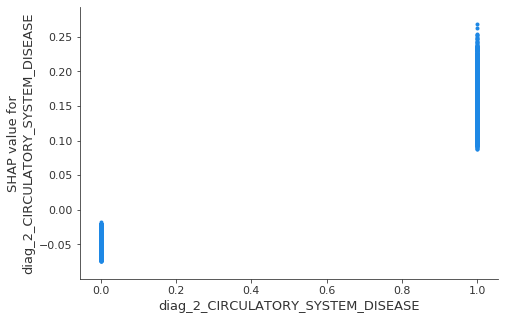

In [102]:
shap.dependence_plot("diag_2_CIRCULATORY_SYSTEM_DISEASE", shap_values2, X_test, interaction_index=None)

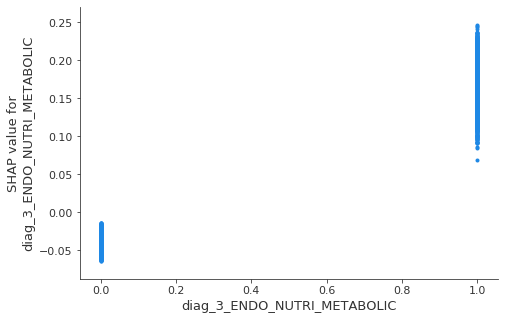

In [103]:
shap.dependence_plot("diag_3_ENDO_NUTRI_METABOLIC", shap_values2, X_test, interaction_index=None)